### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ(バネ定数Kと平衡長R)を学習する

### 必要なパッケージを読み込む

In [60]:
using Flux, Plots
using ChainRulesCore

### ポテンシャルエネルギー関数の定義

In [61]:
function compute_energy(coords1, coords2, K, R)
    ene = K * (sqrt(sum((coords1 .- coords2).^2)) .- R).^2
    return ene
end

compute_energy (generic function with 1 method)

In [62]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, K, R)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    fac = 2.0 * K * (r - R) / r
    ene = K * (r - R)^2

    function compute_energy_pullback(dE)
        dcoords1 = fac .* dx .* dE
        dcoords2 = - dcoords1
        dK = (r - R)^2 * dE
        dR = - 2 * K * (r - R) * dE
        return NoTangent(), dcoords1, dcoords2, dK, dR
    end
    return ene, compute_energy_pullback
end

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [63]:
struct Energy
    P::AbstractArray #P[1] = K, P[2] = R
end

Flux.@functor Energy (P,)

(m::Energy)(coords) = compute_energy(coords..., m.P[1], m.P[2])

In [64]:
# カスタムレイヤでポテンシャルエネルギー値を計算できるかテスト
m = Energy([1.0, 1.0])
coords = ([0.0, 0.0, 0.0], [3.0, 0.0, 0.0])
m(coords)

4.0

### 訓練データの作成

In [65]:
K_true = 3.0
R_true = 0.3
nframe = 100

X_train = []
y_train = []
for iframe = 1:nframe
    coords1 = randn(3)
    coords2 = randn(3)
    push!(X_train, (coords1, coords2))
    push!(y_train, compute_energy(coords1, coords2, K_true, R_true))
end

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [66]:
# Lossの定義
m = Energy([1.0, 1.0])
loss(X, y) = Flux.Losses.mse(m.(X), y)
loss(X_train, y_train)

295.2708405075154

In [67]:
# DataやOptimizerの定義
train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(0.1)

Adam(0.1, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [68]:
# 訓練
loss_train = []

for epoch in 1:100
    for (X, y) in train_loader
        gs = gradient(() -> loss(X, y), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
    push!(loss_train, loss(X_train, y_train))
end

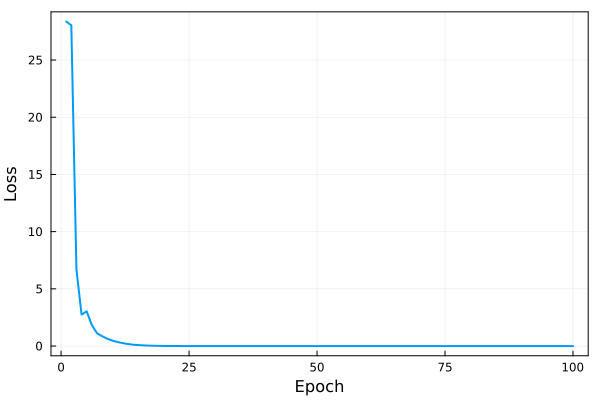

In [69]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [70]:
println("Ground-truth K: ", K_true)
println("Estimate K:     ", m.P[1])

println("Ground-truth R: ", R_true)
println("Estimate R:     ", m.P[2])

Ground-truth K: 3.0
Estimate K:     3.000000000000001
Ground-truth R: 0.3
Estimate R:     0.30000000000000043
